In [48]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

# 读取csv文件
csv_file = "Pfp_20241018.csv"
combined_data = pd.read_csv(csv_file)

# 创建一个函数来计算分子的指纹
def calculate_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # Get the indices of phosphorus atoms in the molecule
        p_atom_indices = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomicNum() == 15]  # 15 is the atomic number for phosphorus
        
        # Generate ECFP for phosphorus atoms
        ecfp_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=5, fromAtoms=p_atom_indices, nBits=512)
        # ecfp_fp = AllChem.MorganGenerator(mol, radius=5, fromAtoms=p_atom_indices, nBits=512)
        
        return list(ecfp_fp)
    else:
        return [0] * 512  # 返回一个全零向量以表示无效分子

# 对每一行的SMILES进行指纹计算
combined_data['Fingerprint_Product'] = combined_data['SMILES'].apply(calculate_fingerprint)
combined_data.to_csv(csv_file)

[15:34:10] DEPRECATION WARNING: please use MorganGenerator
[15:34:10] DEPRECATION WARNING: please use MorganGenerator
[15:34:10] DEPRECATION WARNING: please use MorganGenerator
[15:34:10] DEPRECATION WARNING: please use MorganGenerator
[15:34:10] DEPRECATION WARNING: please use MorganGenerator
[15:34:10] DEPRECATION WARNING: please use MorganGenerator
[15:34:10] DEPRECATION WARNING: please use MorganGenerator
[15:34:10] DEPRECATION WARNING: please use MorganGenerator
[15:34:10] DEPRECATION WARNING: please use MorganGenerator
[15:34:10] DEPRECATION WARNING: please use MorganGenerator
[15:34:10] DEPRECATION WARNING: please use MorganGenerator
[15:34:10] DEPRECATION WARNING: please use MorganGenerator
[15:34:10] DEPRECATION WARNING: please use MorganGenerator
[15:34:10] DEPRECATION WARNING: please use MorganGenerator
[15:34:10] DEPRECATION WARNING: please use MorganGenerator
[15:34:10] DEPRECATION WARNING: please use MorganGenerator
[15:34:10] DEPRECATION WARNING: please use MorganGenerat

/tmp/ipykernel_1119042/3832574215.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(reduced_data[mask, 0], reduced_data[mask, 1], c=(1.0, 0.8, 0.4), label='Initial dataset',s=10)


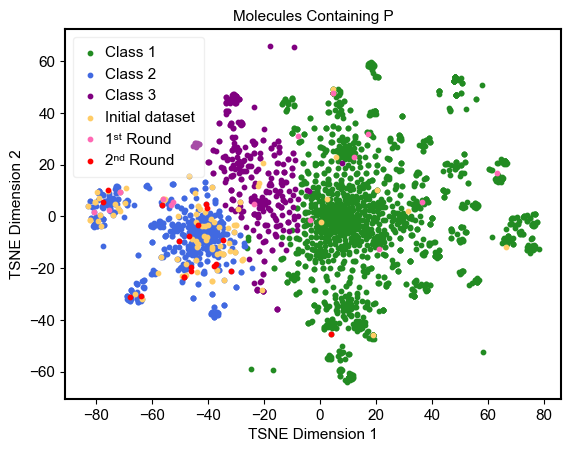

In [4]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import ast
from matplotlib.font_manager import FontProperties

file_name = 'Pfp_20241018.csv'
superscript_st = "ˢᵗ"
superscript_nd = "ⁿᵈ"

# Create a function to calculate t-SNE and visualize K-means clustering
def tsne_kmeans(df, n_clusters=8):  # Change the default number of clusters to 8
    # # Convert the list of fingerprints to a NumPy array
    df['Fingerprint_Product'] = df['Fingerprint_Product'].apply(lambda x: [float(i) for i in ast.literal_eval(x)])
    fingerprints = np.array(df['Fingerprint_Product'].tolist())

    # Apply K-means clustering in the original dimension
    kmeans = KMeans(n_clusters=n_clusters, random_state=87)
    df['Cluster'] = kmeans.fit_predict(fingerprints)
    cluster_sizes = df.groupby('Cluster').size().sort_values(ascending=False).index
    df['Cluster'] = df['Cluster'].map({cluster: idx for idx, cluster in enumerate(cluster_sizes)})
    # Use t-SNE to visualize the clustered data in 2D
    tsne = TSNE(n_components=2, random_state=42)
    reduced_data = tsne.fit_transform(fingerprints)

    # Save t-SNE dimensions to the DataFrame
    df['TSNE_Dimension_1'] = reduced_data[:, 0]
    df['TSNE_Dimension_2'] = reduced_data[:, 1]
    
    
    df.to_csv(file_name)
    
    
    new_df = pd.DataFrame({
    'TSNE_Dimension_1': df['TSNE_Dimension_1'],
    'TSNE_Dimension_2': df['TSNE_Dimension_2']
})
    reduced_data = new_df.to_numpy()

    return df, reduced_data

def draw_TSNE(n_clusters=4):
    # Assuming you have the 'combined_data' DataFrame with 'Smiles', 'Source_Label', and 'Fingerprint_Product' columns
    combined_data = pd.read_csv(file_name)
    # Apply K-means clustering and t-SNE to the data
    combined_data, reduced_data = tsne_kmeans(combined_data, n_clusters)  # Adjust the clustering number to 8
    # print(reduced_data)
    # print(type(reduced_data))
    # print(reduced_data.shape)
    # Plot the data in 2D with different colors for clusters and Source_Label
    colors = ['#228B22',  '#4169E1', 'purple','#DAA520', 'm', 'y', 'orange', 'purple']
    for cluster in range(n_clusters):  # Adjust the loop range to match the number of clusters
        mask = (combined_data['Source_Label'] == 'commercial') & (combined_data['Cluster'] == cluster)
        plt.scatter(reduced_data[mask, 0], reduced_data[mask, 1], c=colors[cluster], label=f'Class {cluster+1}',s=10)
    
    # Plot the "CO2RR" data in black
    # mask = (combined_data['Source_Label'] == 'CO2RR')&(combined_data["High_performance"]!=True)
    mask = (combined_data['Source_Label'] == 'Initial dataset')
    # plt.scatter(reduced_data[mask, 0], reduced_data[mask, 1], c=(1.0, 0.8, 0.4), label='tested',s=10)
    plt.scatter(reduced_data[mask, 0], reduced_data[mask, 1], c=(1.0, 0.8, 0.4), label='Initial dataset',s=10)
    mask = (combined_data['Source_Label'] == f'1{superscript_st} Round')
    plt.scatter(reduced_data[mask, 0], reduced_data[mask, 1], c='#FF69B4', label=f'1{superscript_st} Round',s=10)
    mask = (combined_data['Source_Label'] == f'2{superscript_nd} Round')
    plt.scatter(reduced_data[mask, 0], reduced_data[mask, 1], c='red', label=f'2{superscript_nd} Round',s=10)
    
    #Plot High_performance
    # mask = (combined_data['Source_Label'] == 'CO2RR')& (combined_data["High_performance"]==True)
    # plt.scatter(reduced_data[mask, 0], reduced_data[mask, 1], c="red", marker="*",label='HP',s=12)

    ax = plt.gca()  # Get the current axes
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    font = FontProperties(fname="ARIAL.TTF", size=11)
    plt.legend(handlelength=1, handletextpad=0.5,framealpha=0.3,borderpad=0.6,fontsize=10,prop=font)
    plt.title('Molecules Containing P'.format(n_clusters),fontproperties=font)
    # plt.legend()
    plt.xticks(fontproperties=font)
    plt.yticks(fontproperties=font)
    plt.xlabel('TSNE Dimension 1',fontproperties=font)
    plt.ylabel('TSNE Dimension 2',fontproperties=font)
    plt.savefig("P_ MAP1018.png",dpi=800)
    
    plt.show()
draw_TSNE(3)
#(1.0, 0.8, 0.4)